# Evolutionary Robot Path Planning

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from shapely import LineString, MultiLineString, MultiPolygon, Point, clip_by_rect, box, affinity
from shapely.plotting import plot_polygon, plot_line
from matplotlib import animation
from IPython.display import clear_output


Using matplotlib backend: module://matplotlib_inline.backend_inline


In [3]:
class Obstacle:

    def __init__(self, xlim: tuple, ylim: tuple, permeability=1, velocity=(0, 0)):
        self.xlim = np.array(xlim)
        self.ylim = np.array(ylim)
        self.shape = box(xlim[0], ylim[0], xlim[1], ylim[1])
        self.permeability = permeability
        self.velocity = velocity

    def update_position(self):
        self.xlim += self.velocity[0]
        self.ylim += self.velocity[1]


In [4]:
class Robot:
    """Agent class representing the robot."""

    def __init__(self, loc, target, params):
        """Initializes the attributes.
        loc: tuple(x,y) representing robots current/start coordinates
        fit_land: FtinessLandscape object
        target: tuple(x,y) representing target coordinates
        """
        self.loc = Point(loc)
        self.target = Point(target)
        self.obstacles = MultiPolygon()
        self.artists = []

        # Sensor and actuator params
        self.view_distance = params.get('view_distance', 10) # Must be >= step_distance
        self.step_distance = params.get('step_distance', 10)
        self.turn_angle = params.get('turn_angle', 180) # Max turning angle in degrees

        # Sensor and actuator values
        self.view = clip_by_rect(self.loc.buffer(self.view_distance), 0, 0, self.target.x, self.target.y)

        # History
        self.num_steps = 0
        self.pathHist = []

    def find_waypoint(self):
        """Returns the coordinates for the next motion as a Point object.

        TODO: Doesn't necessarily have to always go full distance,
        maybe edit so step_distance is treated as the max travel distance 
        rather than the distance for every step
        """

        # Calculate ideal waypoint as straight line from robot towards target
        # Using view_distance so it calculates based what it sees beyond where it can move
        idealWaypoint = LineString([self.loc, self.target]).interpolate(self.view_distance)
        idealPath = LineString([self.loc, idealWaypoint])

        path = idealPath
        rng = np.random.default_rng()

        # If the chosen path intersects with a detected obstacle, rotate the path a random amount up to self.turn_angle degrees
        while self.obstacles.intersects(path):
            path = affinity.rotate(path, rng.integers(self.turn_angle), (self.loc.x, self.loc.y))


        return path.interpolate(self.step_distance)
    
    def step(self, env):
        """Performs motion to next calculated waypoint and updates history."""
        next = self.find_waypoint()
        path = LineString([self.loc, next])
        self.pathHist.append(path) 
        self.loc = next
        self.view = clip_by_rect(self.loc.buffer(self.view_distance), 0, 0, env.size[0], env.size[1])
        self.obstacles = env.detect_obstacles(self)
        self.num_steps += 1
        
    def draw(self, ax):
        """Plotsthe robot path."""

        # If robots have different targets or start points, uncomment
        #ax.plot(self.loc.x, self.loc.y, 'bX', markersize=7, zorder=100)
        #ax.plot(self.target.x, self.target.y, 'r*', markersize=10)

        self.artists.clear()
        hist = MultiLineString(self.pathHist)
        
        container = ax.plot(self.loc.x, self.loc.y, 'o', markersize=7, zorder=100, color='darkorange')
        self.artists.append(container)
        container = plot_line(hist, ax=ax, linestyle=':', ec='black', color='lightblue')
        self.artists.append(container[0])
        container = plot_polygon(self.obstacles, ax=ax, color=(1, 0, 0, 1), add_points=False)
        self.artists.append(container)
        container = plot_polygon(self.view, ax=ax, add_points=False, linestyle='--', edgecolor='red', facecolor=(0,0,0,0))
        self.artists.append(container)

        return self.artists
    

In [ ]:
from time import sleep


class Simulation:
    
    def __init__(self, size: tuple, start : tuple, objective: tuple, num_agents=10):
        self.size = size
        self.start = start
        self.objective = objective
        self.num_agents = num_agents

        self.agents = []
        self.obstacles = []

        self.fig, self.ax = plt.subplots()

    def run():
        # Create agents here?
        # Find optimal path
        pass
        
    def add_obstacles(self, obstacles):
        self.obstacles.extend(obstacles)

    def draw_path(self, path):
        # Keeping this general for now - could take in the agent instead of the path in the future
        # Path format can also be changed

        # Setup figure and axis
        fig, ax = plt.subplots()
        fig.set_size_inches((7, 7))
        ax.set_xlim(0, self.size[0])
        ax.set_ylim(0, self.size[1])
        ax.set_axis_off()

        # Start and objective
        ax.plot(self.start[0], self.start[1], 'bX', markersize=7)
        ax.plot(self.objective[0], self.objective[1], 'r*', markersize=10)

        # Obstacles
        for obs in self.obstacles:
            ax.add_patch(patches.Rectangle((obs.xlim[0], obs.ylim[0]), obs.xlim[1] - obs.xlim[0], obs.ylim[1] - obs.ylim[0],
                                           color='black', alpha=obs.permeability))

        # Path
        for i, pos in enumerate(path[:-1]):
            next_pos = path[i+1]
            ax.plot((pos[0], next_pos[0]), (pos[1], next_pos[1]), 
                     linestyle='--', marker='.', color='black', mfc='blue', mec='blue', markersize=7)
            
    def detect_obstacles(self, robot: Robot):
        """Returns polygons representing visible parts of obstacles to robot.
        TODO: Should robot remember past detected obstacles? So if it revisits an area it would already know of the obstacle
        """
        return MultiPolygon([obs.shape.intersection(robot.view) for obs in self.obstacles])
    
    def add_agent(self):
        new_agent = Robot(self.start, self.objective, dict())
        self.agents.append(new_agent)

    def step(self):
        for agent in self.agents:
            agent.step(self)

    def draw(self):
        """Plots obstacles, start/target coords, and path/view of each robot"""
        self.ax.set_xlim(0, self.size[0])
        self.ax.set_ylim(0, self.size[1])

        obstacles = MultiPolygon([obs.shape] for obs in self.obstacles)
        plot_polygon(obstacles, ax=self.ax, color='black', add_points=False)
        self.ax.plot(self.start[0], self.start[1], 'bX', markersize=7, zorder=10)
        self.ax.plot(self.objective[0], self.objective[1], 'r*', markersize=10)

    def animate(self):
        # Remove previous artists for rerender
        [[artist.remove() if type(artist) is not list else artist[0].remove() for artist in robot.artists] for robot in self.agents]
        artists = ([robot.draw(self.ax) for robot in self.agents])
        return artists

    def run_full(self):
        """Run simulation and plot every 1s until all robots reach target"""
        self.draw()
        while all([robot.loc != robot.target for robot in self.agents]):  
            self.animate()
            display(self.fig)
            sleep(0.5)
            self.step()
            clear_output(wait=True)
        
        self.animate()
            

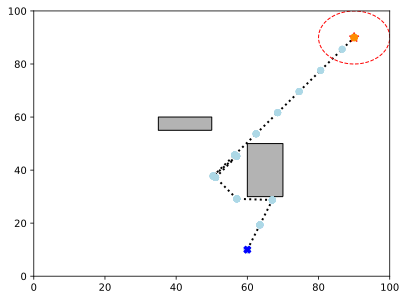

In [89]:
# Test
start = (60, 10)
objective = (90, 90)
sim = Simulation((100, 100), start, objective)

obstacles = (Obstacle((35, 50), (55, 60)), Obstacle((60, 70), (30, 50)))
sim.add_obstacles(obstacles)
sim.add_agent()
sim.run_full()

#sim.draw_path([start, (50, 50), (75, 80), objective])